## Using LSTM to analyze resting state networks

This notebook includes code to classify ADHD from healthy controls using LSTM model with rs-fMRI data.

First let's import the relevant libraries

In [3]:
!pip install nilearn
from nilearn import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#nilearn - neuroimaging tailored library
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

#keras - for NN models
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import LSTM
from keras import optimizers
from keras.utils import plot_model
from keras import utils
from sklearn.metrics import roc_curve


#scipy- statistical analysis tools
from scipy.stats import ttest_1samp
#from scipy import interp



## Preparing data for analysis ##

Import data, and exctract features

In [4]:
## load the smith (ICA based) mask
## 'rsn10': 10 ICA maps from the above that matched across task and rest
# http://brainmap.org/pubs/SmithPNAS09.pdf

smith_atlas = datasets.fetch_atlas_smith_2009()
smith_atlas_rs_networks = smith_atlas.rsn70


[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/smith_2009

[fetch_single_file] Downloading data from https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/rsn20.nii.gz ...

[_chunk_report_] Downloaded 3473408 of 15129514 bytes (23.0%%,    3.4s remaining)

[_chunk_report_] Downloaded 13590528 of 15129514 bytes (89.8%%,    0.2s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/PNAS_Smith09_rsn10.nii.gz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/rsn70.nii.gz ...

[_chunk_report_] Downloaded 11714560 of 53028809 bytes (22.1%%,    3.5s remaining)

[_chunk_report_] Downloaded 28442624 of 53028809 bytes (53.6%%,    1.8s remaining)

[_chunk_report_] Downloaded 47841280 of 53028809 bytes (90.2%%,    0.3s remaining)

[fetch_single_file]  ...done. (4 seconds, 0 min)

[fetch_single_file] Downloading data from https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/bm20.nii.gz ...

[_chunk_report_] Downloaded 4636672 of 19114114 bytes (24.3%%,    3.2s remaining)

[_chunk_report_] Downloaded 18481152 of 19114114 bytes (96.7%%,    0.1s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[fetch_single_file] Downloading data from 
https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/PNAS_Smith09_bm10.nii.gz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[fetch_single_file] Downloading data from https://www.fmrib.ox.ac.uk/datasets/brainmap+rsns/bm70.nii.gz ...

[_chunk_report_] Downloaded 19660800 of 67017538 bytes (29.3%%,    3.1s remaining)

[_chunk_report_] Downloaded 40460288 of 67017538 bytes (60.4%%,    1.5s remaining)

[_chunk_report_] Downloaded 52682752 of 67017538 bytes (78.6%%,    0.9s remaining)

[fetch_single_file]  ...done. (4 seconds, 0 min)

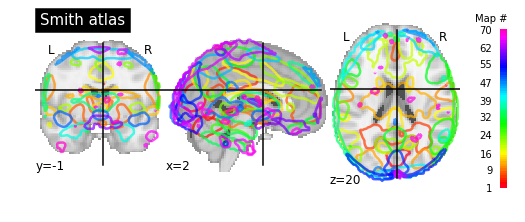

In [ ]:
plotting.plot_prob_atlas(smith_atlas_rs_networks,
                         title='Smith atlas',
                         colorbar=True)
plotting.show()

In [5]:
# Import preprocessed, ready-to-go, datasets
adhd_data=datasets.fetch_adhd(n_subjects=50)

[get_dataset_dir] Dataset created in /root/nilearn_data/adhd

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7781/adhd40_metadata.tgz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/fbef5baff0b388a8c913a08e1d84e059/adhd40_metadata.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7782/adhd40_0010042.tgz ...

[_chunk_report_] Downloaded 20299776 of 44414948 bytes (45.7%%,    1.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010042.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7783/adhd40_0010064.tgz ...

[_chunk_report_] Downloaded 26116096 of 45583539 bytes (57.3%%,    0.7s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010064.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7784/adhd40_0010128.tgz ...

[_chunk_report_] Downloaded 28164096 of 45461055 bytes (62.0%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0010128.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7785/adhd40_0021019.tgz ...

[_chunk_report_] Downloaded 28033024 of 46216320 bytes (60.7%%,    0.7s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0021019.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7786/adhd40_0023008.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023008.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7787/adhd40_0023012.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0023012.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7788/adhd40_0027011.tgz ...

[_chunk_report_] Downloaded 28803072 of 72402326 bytes (39.8%%,    1.5s remaining)

[_chunk_report_] Downloaded 57655296 of 72402326 bytes (79.6%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027011.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7789/adhd40_0027018.tgz ...

[_chunk_report_] Downloaded 28426240 of 76184603 bytes (37.3%%,    1.7s remaining)

[_chunk_report_] Downloaded 57384960 of 76184603 bytes (75.3%%,    0.7s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027018.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7790/adhd40_0027034.tgz ...

[_chunk_report_] Downloaded 28680192 of 70074120 bytes (40.9%%,    1.5s remaining)

[_chunk_report_] Downloaded 57532416 of 70074120 bytes (82.1%%,    0.4s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027034.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7791/adhd40_0027037.tgz ...

[_chunk_report_] Downloaded 26714112 of 69291635 bytes (38.6%%,    1.6s remaining)

[_chunk_report_] Downloaded 55418880 of 69291635 bytes (80.0%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_0027037.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7792/adhd40_1019436.tgz ...

[_chunk_report_] Downloaded 27893760 of 41803342 bytes (66.7%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1019436.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7793/adhd40_1206380.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1206380.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7794/adhd40_1418396.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1418396.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7795/adhd40_1517058.tgz ...

[_chunk_report_] Downloaded 23961600 of 62682233 bytes (38.2%%,    1.6s remaining)

[_chunk_report_] Downloaded 52830208 of 62682233 bytes (84.3%%,    0.4s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1517058.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7796/adhd40_1552181.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1552181.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7797/adhd40_1562298.tgz ...

[_chunk_report_] Downloaded 28680192 of 60663491 bytes (47.3%%,    1.1s remaining)

[_chunk_report_] Downloaded 57655296 of 60663491 bytes (95.0%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1562298.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7798/adhd40_1679142.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_1679142.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7799/adhd40_2014113.tgz ...

[_chunk_report_] Downloaded 28164096 of 33119052 bytes (85.0%%,    0.2s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2014113.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7800/adhd40_2497695.tgz ...

[_chunk_report_] Downloaded 28557312 of 45455025 bytes (62.8%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2497695.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7801/adhd40_2950754.tgz ...

[_chunk_report_] Downloaded 28680192 of 57992968 bytes (49.5%%,    1.0s remaining)

[_chunk_report_] Downloaded 57532416 of 57992968 bytes (99.2%%,    0.0s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_2950754.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7802/adhd40_3007585.tgz ...

[_chunk_report_] Downloaded 28950528 of 67925261 bytes (42.6%%,    1.4s remaining)

[_chunk_report_] Downloaded 58310656 of 67925261 bytes (85.8%%,    0.3s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3007585.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7803/adhd40_3154996.tgz ...

[_chunk_report_] Downloaded 28557312 of 32919780 bytes (86.7%%,    0.2s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3154996.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7804/adhd40_3205761.tgz ...

[_chunk_report_] Downloaded 28557312 of 59835286 bytes (47.7%%,    1.1s remaining)

[_chunk_report_] Downloaded 57630720 of 59835286 bytes (96.3%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3205761.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7805/adhd40_3520880.tgz ...

[_chunk_report_] Downloaded 28557312 of 61857076 bytes (46.2%%,    1.2s remaining)

[_chunk_report_] Downloaded 57384960 of 61857076 bytes (92.8%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3520880.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7806/adhd40_3624598.tgz ...

[_chunk_report_] Downloaded 28778496 of 59385206 bytes (48.5%%,    1.1s remaining)

[_chunk_report_] Downloaded 57262080 of 59385206 bytes (96.4%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3624598.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7807/adhd40_3699991.tgz ...

[_chunk_report_] Downloaded 28426240 of 41518251 bytes (68.5%%,    0.5s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3699991.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7808/adhd40_3884955.tgz ...

[_chunk_report_] Downloaded 28033024 of 32108848 bytes (87.3%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3884955.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7809/adhd40_3902469.tgz ...

[_chunk_report_] Downloaded 28286976 of 39415752 bytes (71.8%%,    0.4s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3902469.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7810/adhd40_3994098.tgz ...

[_chunk_report_] Downloaded 28680192 of 59297020 bytes (48.4%%,    1.1s remaining)

[_chunk_report_] Downloaded 57679872 of 59297020 bytes (97.3%%,    0.1s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_3994098.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7811/adhd40_4016887.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4016887.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7812/adhd40_4046678.tgz ...

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4046678.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7813/adhd40_4134561.tgz ...

[_chunk_report_] Downloaded 28426240 of 69914913 bytes (40.7%%,    1.5s remaining)

[_chunk_report_] Downloaded 57384960 of 69914913 bytes (82.1%%,    0.4s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4134561.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7814/adhd40_4164316.tgz ...

[_chunk_report_] Downloaded 28680192 of 45506732 bytes (63.0%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4164316.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7815/adhd40_4275075.tgz ...

[_chunk_report_] Downloaded 28819456 of 32363673 bytes (89.0%%,    0.1s remaining)

[fetch_single_file]  ...done. (1 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_4275075.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7816/adhd40_6115230.tgz ...

[_chunk_report_] Downloaded 28819456 of 73484949 bytes (39.2%%,    1.6s remaining)

[_chunk_report_] Downloaded 57778176 of 73484949 bytes (78.6%%,    0.5s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_6115230.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7817/adhd40_7774305.tgz ...

[_chunk_report_] Downloaded 27107328 of 42188959 bytes (64.3%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_7774305.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7818/adhd40_8409791.tgz ...

[_chunk_report_] Downloaded 28450816 of 70396354 bytes (40.4%%,    1.5s remaining)

[_chunk_report_] Downloaded 54902784 of 70396354 bytes (78.0%%,    0.6s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8409791.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7819/adhd40_8697774.tgz ...

[_chunk_report_] Downloaded 28557312 of 45075978 bytes (63.4%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_8697774.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7820/adhd40_9744150.tgz ...

[_chunk_report_] Downloaded 28557312 of 63380505 bytes (45.1%%,    1.2s remaining)

[_chunk_report_] Downloaded 57434112 of 63380505 bytes (90.6%%,    0.2s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9744150.tgz...

[uncompress_file] .. done.

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7821/adhd40_9750701.tgz ...

[_chunk_report_] Downloaded 28688384 of 46607053 bytes (61.6%%,    0.6s remaining)

[fetch_single_file]  ...done. (2 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/adhd/49718167d83b032094ad6d17e64b4e49/adhd40_9750701.tgz...

[uncompress_file] .. done.

In [6]:
# exploring the header of one image
import nibabel as nib
img=nib.load(adhd_data['func'][0])

print(img.header['dim'])
print(img.header['pixdim'])


[  4  61  73  61 176   1   1   1]
[-1.  3.  3.  3.  2.  0.  0.  0.]


In [7]:
# Region signals extraction- exctract the values of the ten networks

masker = NiftiMapsMasker(maps_img=smith_atlas_rs_networks,  # Smith stals
                         standardize=True, # centers and norms the time-series
                         memory='nilearn_cache', # cache
                         verbose=0) #do not print verbose

In [8]:
all_subjects_data=[]
labels=[]  # 1 if ADHD, 0 if control

for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):

    time_series = masker.fit_transform(func_file, confounds=confound_file)

    all_subjects_data.append(time_series)
    labels.append(phenotypic['adhd'])


In [9]:
print('N control:' ,labels.count(0))
print('N adhd:' ,labels.count(1))

N control: 20
N adhd: 20


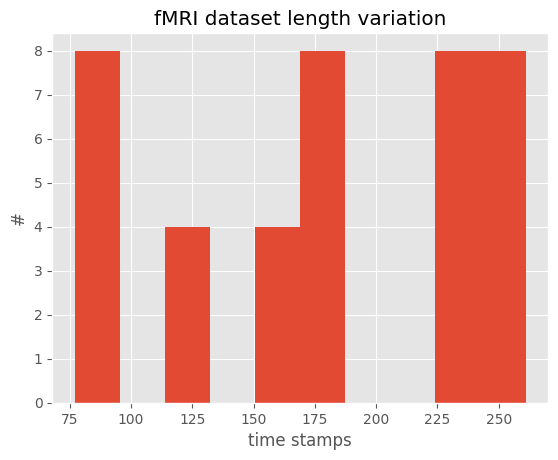

In [10]:
plt.hist([len(i) for i in all_subjects_data])
plt.title('fMRI dataset length variation')
plt.xlabel('time stamps')
plt.ylabel('#')
plt.show()

In [11]:
# find the longest image
max_len_image=np.max([len(i) for i in all_subjects_data])


In [12]:
# reshape

all_subjects_data_reshaped=[]
for subject_data in all_subjects_data:
  # Padding
  N= max_len_image-len(subject_data)
  padded_array=np.pad(subject_data, ((0, N), (0,0)),
                      'constant', constant_values=(0))
  subject_data=padded_array
  subject_data=np.array(subject_data)
  subject_data.reshape(subject_data.shape[0],subject_data.shape[1],1)
  all_subjects_data_reshaped.append(subject_data)


In [13]:
# shape of data

# 40 subjects
# 261 time stamps
# 10 netwroks values

np.array(all_subjects_data_reshaped).shape

(40, 261, 70)

In [14]:
# The data, split between train and test sets.

def get_train_test(X, y, i, verbrose=False):
  '''
  split to train and test and reshape data
  X data
  y labels
  i random state
  '''
  X_train, X_test, y_train, y_test = train_test_split(X,
                                        y, test_size=0.2, random_state=i)



  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=np.array(all_subjects_data_reshaped).shape[1]
  RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 2)
  y_test = utils.to_categorical(y_test, 2)

  return X_train, X_test, y_train, y_test



## Build the LSTM model

In [16]:
# create the model

model = Sequential()

# LSTM layers -
# Long Short-Term Memory layer - Hochreiter 1997.
t_shape=np.array(all_subjects_data_reshaped).shape[1]
RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

model.add(LSTM(units=70, # dimensionality of the output space
               dropout=0.4, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, # Fraction of the units to drop (recurent state)
               return_sequences=True, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(LSTM(units=60,
               dropout=0.4,
               recurrent_dropout=0.15,
               return_sequences=True))

model.add(LSTM(units=50,
               dropout=0.4,
               recurrent_dropout=0.15,
               return_sequences=True))

model.add(LSTM(units=40,
               dropout=0.4,
               recurrent_dropout=0.15,
               return_sequences=False))


model.add(Dense(units=2,
                activation="sigmoid"))

model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(learning_rate=0.001),
                metrics=['binary_accuracy'])

print(model.summary())



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 261, 70)             │          39,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 261, 60)             │          31,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 261, 50)             │          22,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              82 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,762 (420.95 KB)

 Trainable params: 107,762 (420.95 KB)

 Non-trainable params: 0 (0.00 B)

None


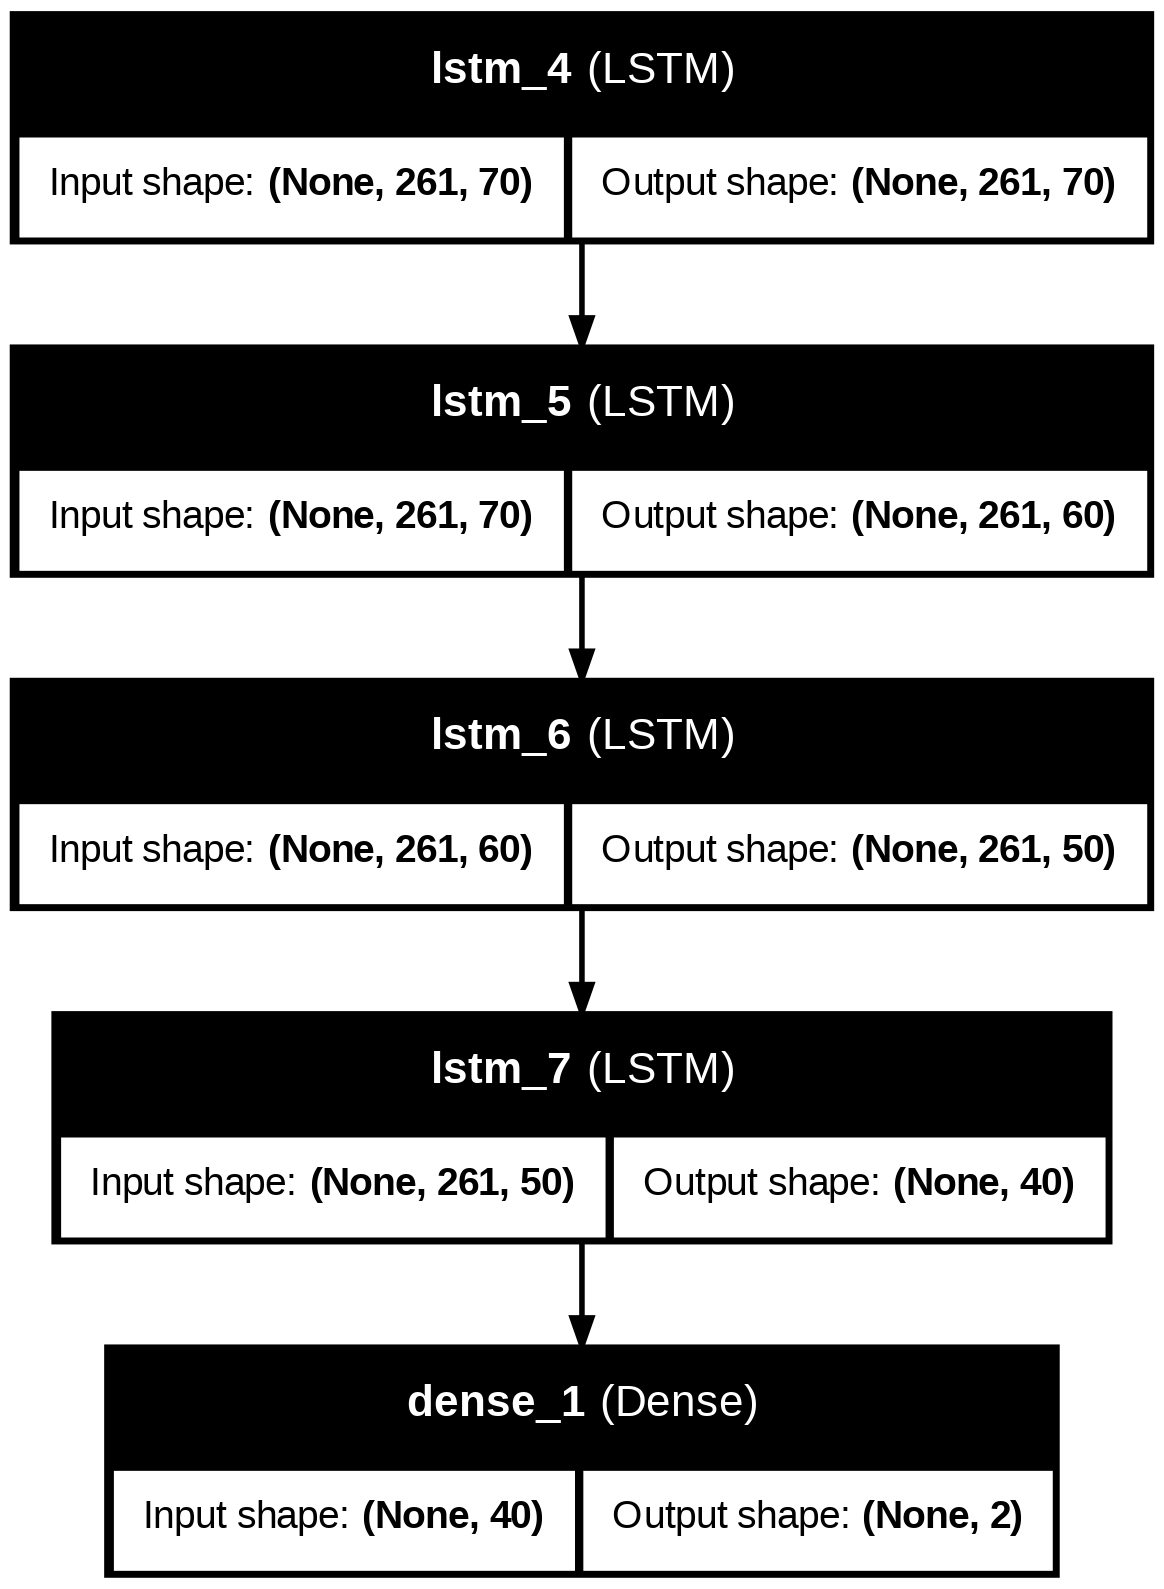

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)


## Train the LSTM model

32 train samples
8 test samples
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - binary_accuracy: 0.4000 - loss: 0.6966 - val_binary_accuracy: 0.5000 - val_loss: 0.6953
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - binary_accuracy: 0.6200 - loss: 0.6867 - val_binary_accuracy: 0.5714 - val_loss: 0.6954
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - binary_accuracy: 0.6400 - loss: 0.6842 - val_binary_accuracy: 0.5714 - val_loss: 0.6954
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - binary_accuracy: 0.6000 - loss: 0.6915 - val_binary_accuracy: 0.5714 - val_loss: 0.6951
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - binary_accuracy: 0.6000 - loss: 0.6904 - val_binary_accuracy: 0.5714 - val_loss: 0.6951
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - binary_accuracy: 0.5200 - loss: 0.6911 - val_binary_accuracy: 0.5000 - val_loss: 0.6952
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - binary_accuracy: 0.6800 - loss: 0.6822 - val_binary_accuracy: 0.5000 - val_loss

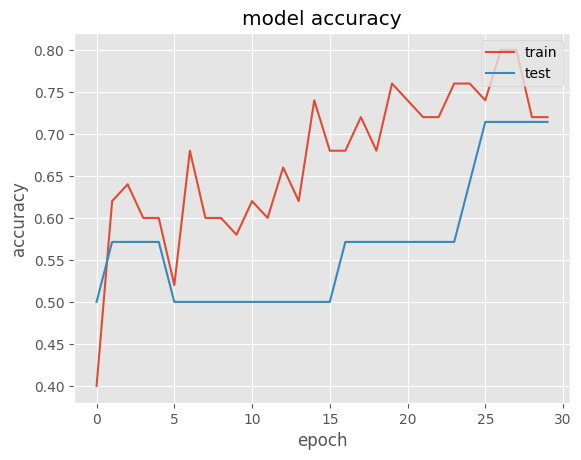

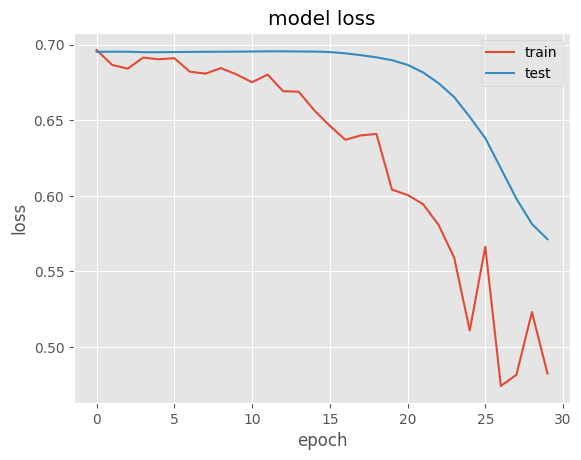

In [18]:
X_train, X_test, y_train, y_test = get_train_test(all_subjects_data_reshaped,
                                                    labels, i=8, verbrose=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30)

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## Evaluate the LSTM model

In [19]:
from sklearn.metrics import accuracy_score

def boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test,
                                    n_iterations=5, n_epochs=50):

  '''
  hypothesis testing function
  X_train, y_train, X_test, y_test- the data
  n_iterations- number of bootdtaping iterations
  n_epochs - number of epochs for model's training
  '''

  accuracy=[] ## model accuracy
  roc_msrmnts_fpr=[] ## false positive rate
  roc_msrmnts_tpr=[] ## true positive rate

  # run bootstrap
  for i in range(n_iterations):
    # prepare train and test sets
    X_train, X_test, y_train, y_test=get_train_test(all_subjects_data_reshaped,
                                              labels, i=i, verbrose=False)
    # fit model
    print('fitting..')
    model.fit(X_train, y_train, validation_split=0.2, epochs=n_epochs)

    # evaluate model
    print('evaluating..')
    y_pred=model.predict(X_test)
    y_test_1d=[i[0] for i in y_test]
    y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]

    fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)

    acc_score = accuracy_score(y_test_1d, y_pred_1d)

    accuracy.append(acc_score)
    roc_msrmnts_fpr.append(fpr)
    roc_msrmnts_tpr.append(tpr)

  return accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr



accuracy, roc_msrmnts_fpr, roc_msrmnts_tpr  = boostrapping_hypothesis_testing(X_train, y_train, X_test, y_test)

fitting..
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - binary_accuracy: 0.4800 - loss: 0.6634 - val_binary_accuracy: 0.6429 - val_loss: 0.3710
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - binary_accuracy: 0.6400 - loss: 0.5987 - val_binary_accuracy: 0.7143 - val_loss: 0.3818
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - binary_accuracy: 0.6400 - loss: 0.5541 - val_binary_accuracy: 0.7143 - val_loss: 0.3905
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step - binary_accuracy: 0.6000 - loss: 0.5803 - val_binary_accuracy: 0.7143 - val_loss: 0.3918
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step - binary_accuracy: 0.6400 - loss: 0.6130 - val_binary_accuracy: 0.7143 - val_loss: 0.3864
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - binary_accuracy: 0.5600 - loss: 0.5899 - val_binary_accuracy: 0.7143 - val_loss: 0.3639
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step - binary_accuracy: 0.6200 - loss: 0.5868 - val_binary_accuracy: 0.8571 - val_loss: 0.3526
Epoch 8/50

In [21]:
#def calc_p_val(stats, h0, n_iterations):
def calc_p_val(stats, h0):
  '''
  finds the p value for the results

  '''
  # calc pval
  tset, pval = ttest_1samp(stats, h0)

  return pval

p_val=calc_p_val(accuracy, .5)

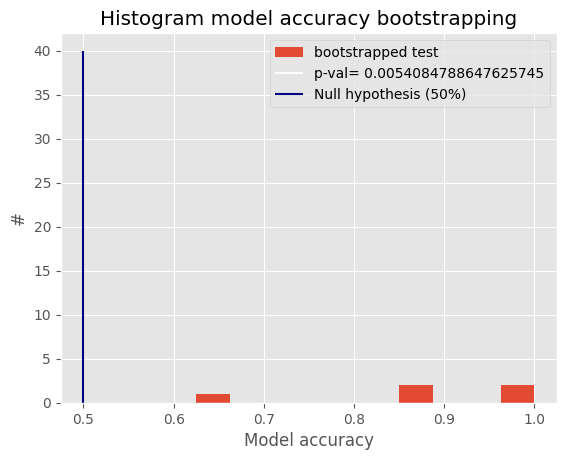

In [22]:
def plot_p_value(stats, p_val):
  '''
  plots the bootstrapping results with the null hypothesis value
  '''

  plt.hist(stats, label='bootstrapped test')
  plt.vlines(.5, 0, 40, color='white', label='p-val= {}'.format(p_val))
  plt.vlines(.5, 0, 40, color='navy', label='Null hypothesis (50%)')

  plt.title('Histogram model accuracy bootstrapping')
  plt.xlabel('Model accuracy')
  plt.ylabel('#')
  plt.legend()
  plt.plot()

plot_p_value(accuracy, p_val)

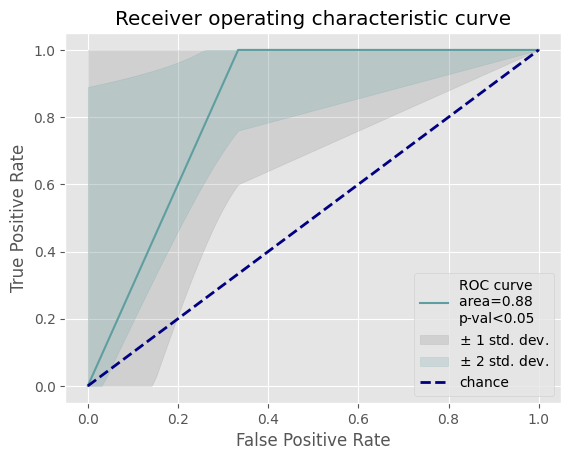

In [23]:
def plot_roc_curve(fpr_vals, tpr_vals, roc_auc, p_val):
  '''
  This function plots the median value of the roc for the boostrapped
    results calculated above.

  fpr stand for false-positive rate
  tpr stands for true-positive rate
  roc_auc is the area under curve
  '''

  ## get the values
  N=len(fpr_vals)
  tprs=[]
  median_fpr=np.linspace(0, 1, 100)
#  tprs=[interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  tprs=[np.interp(median_fpr, fpr_vals[i], tpr_vals[i]) for i in range(N)]
  std_tpr = np.std(tprs, axis=0)

  mean_tpr = np.mean(tprs, axis=0)
  median_tpr=np.median(tprs, axis=0)
  median_tpr[-1] = 1.0

  tprs_upper_2 = np.minimum(mean_tpr + 2*std_tpr, 1)
  tprs_lower_2 = np.maximum(mean_tpr - 2*std_tpr, 0)

  tprs_upper_1 = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower_1 = np.maximum(mean_tpr - std_tpr, 0)

  median_auc_roc=np.median(roc_auc)


  ## plot
  if p_val<0.05:
    p_val=0.05
  plt.plot(median_fpr, median_tpr, color='cadetblue',
           label='ROC curve \narea={} \np-val<{}'.\
            format(np.round(median_auc_roc,2),
                   np.round(p_val,2)))
  plt.fill_between(median_fpr, tprs_lower_2, tprs_upper_2, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

  plt.fill_between(median_fpr, tprs_lower_1, tprs_upper_1, color='cadetblue', alpha=.2,
                 label=r'$\pm$ 2 std. dev.')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label=r'chance')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic curve')
  plt.legend(loc="lower right")

  plt.show()



plot_roc_curve(roc_msrmnts_fpr, roc_msrmnts_tpr, accuracy,p_val)